# Study Mondays relative to previous Fridays

## Monday Trades 

- Inside fridays range % and Fraction 
- Above Fridays Range % and Fraction 
- Below Fridays Range % and Fraction 

Day of week for all 3 that makes the high and low % and Fraction 

## Monday closes 

- Inside fridays range % and Fraction 
- Above Fridays Range % and Fraction 
- Below Fridays Range % and Fraction 

Day of week for all three that makes the high and low % and Fraction

In [1]:
from datetime import datetime
import pandas as pd
import yfinance as yf
import seaborn as sns 

stock_symbol = "NQ=F"
start_date = "2000-01-01"
end_date = "2023-12-08"  # datetime.now()

def get_symbol(stock, start, end):
    df = yf.download(stock, start=start, end=end, progress=False)

    df['year'] = df.index.to_series().dt.isocalendar().year
    df['week'] = df.index.to_series().dt.isocalendar().week
    df['dayofweek'] = df.index.to_series().dt.dayofweek
    return df


# Monday Range compared to Friday
 
Here we are looking at Monday's range compared to Friday's. There are four categories:
- Above: Monday's high is above Friday's high and Monday's low is above Friday's low.
- Below: Monday's high is below Friday's low and Monday's high is below Friday's high.
- Inside: Monday's high and low are inside (or equal to) Friday's high and low.
- Outside: Monday's high is above Friday's high and Monday's low is below Friday's low.
- 

In [2]:
def range_daytype(df):
    """
    This uses dataframe filters to categorize each Monday's range compared to previous Friday.
    :param df: 
    :return: 
    """
    fri_mon = ((df.dayofweek.shift(1) == 4) & (df.dayofweek == 0)) | ((df.dayofweek.shift(-1) == 0) & (df.dayofweek == 4))
    mon_above = fri_mon & (df.dayofweek == 0) & (df.High > df.High.shift(1)) & (df.Low >= df.Low.shift(1))
    mon_below = fri_mon &  (df.dayofweek == 0) & (df.High  <= df.High.shift(1)) & (df.Low < df.Low.shift(1))
    mon_inside = fri_mon & (df.dayofweek == 0) & (df.High  <= df.High.shift(1)) & (df.Low >= df.Low.shift(1))
    mon_outside = fri_mon & (df.dayofweek == 0) & (df.High  > df.High.shift(1)) & (df.Low < df.Low.shift(1))
    df["daytype"] = ""
    df.loc[mon_above, "daytype"] = "above"
    df.loc[mon_below, "daytype"] = "below"
    df.loc[mon_inside, "daytype"] = "inside"
    df.loc[mon_outside, "daytype"] = "outside"
    return df
    
df = get_symbol(stock_symbol, start_date, end_date)
df = range_daytype(df)

daytype
above      454
below      371
outside    132
inside     113
Name: count, dtype: int64

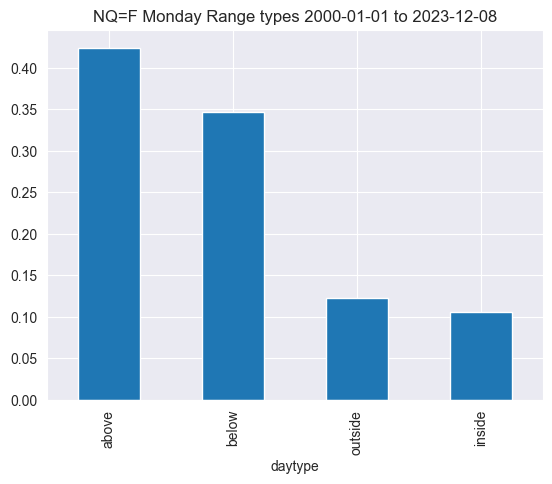

In [3]:
def plot_daytype(df):
    """Plots the daytypes of the Mondays after a (non-holiday) Friday."""
    df[((df.dayofweek.shift(1) == 4) & (df.dayofweek == 0))].daytype.value_counts(normalize=True).plot(kind="bar", title=f"{stock_symbol} Monday Range types {start_date} to {end_date}");
    
plot_daytype(df)
df[((df.dayofweek.shift(1) == 4) & (df.dayofweek == 0))].daytype.value_counts()


## Week high and low
Next we'll scan the remaining days of the week (Tuesday - Friday) and see which day set the week high and week low. This code will be reused in the next section. 

In [4]:
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

def new_day_list():
    hist = pd.Series(data=0, index=day_names.keys())
    hist = pd.DataFrame(columns = ["daytype", "day"])
    return hist


def week_highest(week):
    return week[(week.dayofweek != 0) & (week.High[week.dayofweek != 0] == week.High[week.dayofweek != 0].max())]

def week_lowest(week):
    return week[(week.dayofweek != 0) & (week.Low[week.dayofweek != 0] == week.Low[week.dayofweek != 0].max())]

def scan_weeks(weeks, filter):
    """Iterates the weeks and returns results of the passed in filter.
    The result is a list of datypes and day of week that matched the filter."""
    week_high = new_day_list()
    for name, week in weeks:
        monday = week.loc[(week.dayofweek == 0) & (week.daytype !="") ]
        if monday.empty:
            continue
        daytype = monday["daytype"].iloc[0]
        results = filter(week)
        # sometimes there is a tie
        for day in results.dayofweek:
            week_high.loc[len(week_high.index)] = [daytype, day]
    return week_high

def plot_weekly(df):
    sns.catplot(data=df, x='daytype', y='day', kind='violin');



## The Week High based on the Monday Range

daytype  day
above    1      123
         2       59
         3       96
         4      180
below    1      105
         2       66
         3       73
         4      131
inside   1       40
         2       23
         3       20
         4       33
outside  1       35
         2       32
         3       23
         4       44
Name: count, dtype: int64

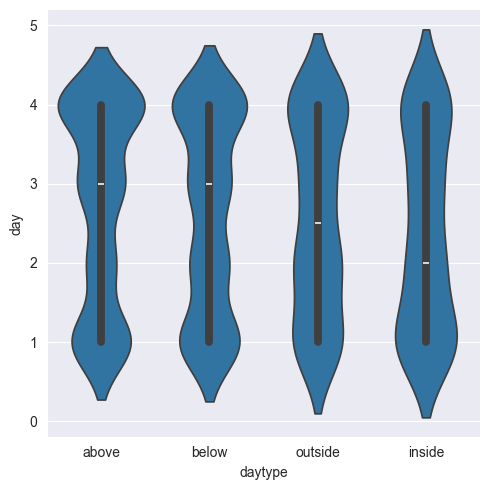

In [5]:
weeks = df.groupby(['year', 'week'])
week_high  = scan_weeks(weeks, week_highest)
plot_weekly(week_high)
week_high.value_counts(sort=False)


## The Week Low based on Monday Range

daytype  day
above    1      130
         2       67
         3       85
         4      175
below    1       94
         2       66
         3       68
         4      145
inside   1       39
         2       23
         3       18
         4       36
outside  1       37
         2       26
         3       16
         4       54
Name: count, dtype: int64

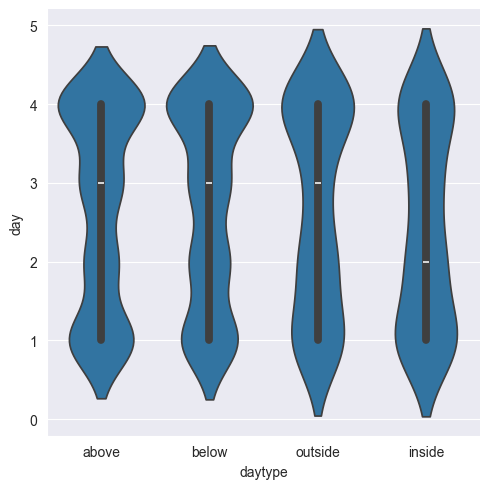

In [6]:
week_low  = scan_weeks(weeks, week_lowest)
plot_weekly(week_low)
week_low.value_counts(sort=False)

# Friday Close compared to Friday's range.
Here we'll use the same data as above but this time will categorize the weeks based on the Friday close. There three categories.

- Above: Friday closed above Friday's high.
- Inside: Friday closed between (and including) Friday's high and low.
- Below; Friday closed below Friday's low.


daytype
inside    525
above     312
below     233
Name: count, dtype: int64

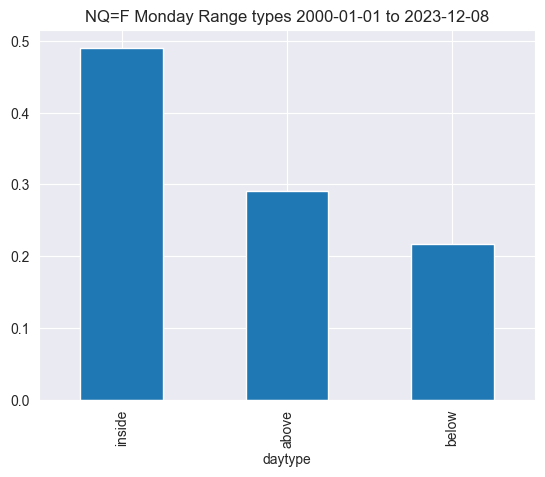

In [7]:
def close_daytype(df):
    fri_mon = ((df.dayofweek.shift(1) == 4) & (df.dayofweek == 0)) | ((df.dayofweek.shift(-1) == 0) & (df.dayofweek == 4))
    mon_above = fri_mon & (df.dayofweek == 0) & (df.Close > df.High.shift(1))
    mon_inside = fri_mon &  (df.dayofweek == 0) & (df.Close  <= df.High.shift(1)) & (df.Close >= df.Low.shift(1))
    mon_below = fri_mon & (df.dayofweek == 0) & (df.Close < df.Low.shift(1))
    df["daytype"] = ""
    df.loc[mon_above, "daytype"] = "above"
    df.loc[mon_below, "daytype"] = "below"
    df.loc[mon_inside, "daytype"] = "inside"
    return df
    
df_close = get_symbol(stock_symbol, start_date, end_date)
df_close = close_daytype(df_close)
plot_daytype(df_close)
df_close[((df_close.dayofweek.shift(1) == 4) & (df_close.dayofweek == 0))].daytype.value_counts()


## The Week High based on Monday Close

daytype  day
above    1       84
         2       53
         3       62
         4      115
below    1       56
         2       42
         3       54
         4       86
inside   1      163
         2       85
         3       96
         4      187
Name: count, dtype: int64

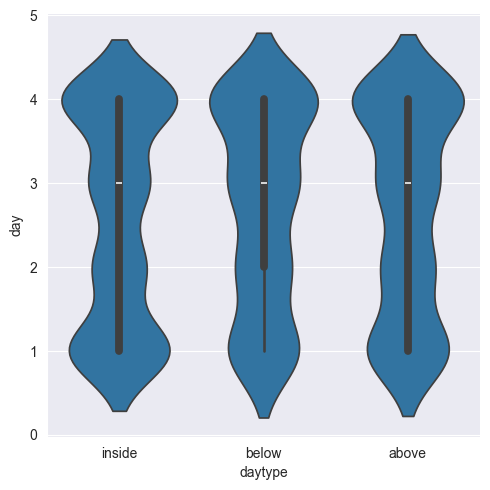

In [8]:
weeks = df_close.groupby(['year', 'week'])
week_high  = scan_weeks(weeks, week_highest)
plot_weekly(week_high)
week_high.value_counts(sort=False)

## The Week Low based on Monday Close

daytype  day
above    1       95
         2       50
         3       53
         4      116
below    1       47
         2       46
         3       48
         4       94
inside   1      158
         2       86
         3       86
         4      200
Name: count, dtype: int64

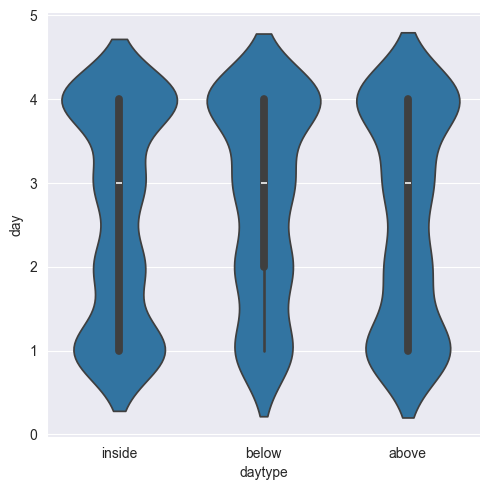

In [9]:
week_low  = scan_weeks(weeks, week_lowest)
plot_weekly(week_low)
week_low.value_counts(sort=False)